In [2]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

## H-bond analysis:

**Note:** As of today (20241222), the latest version of MDAnalysis (2.8) cannot read binary topology files (the ones with the `.tpr` extension) created by gromacs version 2024.4. Binary topology data is necessary for hydrogen bond analysis in `MDAnalysis` for some reason, so I am trying `MDTraj` instead.


In `MDTraj`, the Baker-Hubbard Hydrogen Bond Identification can be used, where the hydrogen bond is said to have formed if:

1. The angle $\theta_{dha}>2\pi/3$, *i.e.*, $120$ degrees, and
2. The distance $r_{ha}<0.25\;nm$. 
   
Here, $d$ means 'donor', 'h' means 'hydrogen', and 'a' means acceptor.
The donors considered by this method are NH and OH, and the acceptors considered are O and N.

Do not load the whole trajectory, as it will take up too much memory. Unlike `MDAnalysis`, `MDTraj` doesn't do lazy loads from disk, but fully operates in memory. This makes it faster, but memory-intensive.

So, we choose a 'stride' of, say, $60$ frames, and have `MDTraj` load every $60^{th}$ frame of the trajectory, then run the baker-hubbard algorithm.

In [4]:
import numpy as np
stride = 3
total_frames = 5000
total_time_ns = 50

timestep  = (stride/total_frames) * total_time_ns

nframes = int(np.ceil(total_frames/stride))

timestep, nframes

(0.03, 1667)

In [5]:
%%time
import numpy as np
import mdtraj as md


topfile='start.pdb'
xtcfile='md_50_compact_compact.xtc'

full_traj = md.load_xtc(xtcfile, stride=stride, top=topfile)
pyc_atoms = full_traj.topology.select('resname PYC')
hbonds = md.baker_hubbard(full_traj, periodic=False, freq=0.01)
label = lambda hbond : '%s - %s ... %s' % ( full_traj.topology.atom(hbond[0]),\
                                            full_traj.topology.atom(hbond[1]),\
                                            full_traj.topology.atom(hbond[2]))
pyc_hbonds = []
for hbond in hbonds:
    d,h,a = hbond
    if d in pyc_atoms or a in pyc_atoms:
        pyc_hbonds.append(hbond)
        print(label(hbond))

pyc_hbonds = np.array(pyc_hbonds)

VAL149-N - VAL149-H ... PYC389-O
ASN210-N - ASN210-H ... PYC389-O
ASN210-N - ASN210-H ... PYC389-N1
ASN210-ND2 - ASN210-HD21 ... PYC389-O
CPU times: user 16.5 s, sys: 7.7 s, total: 24.2 s
Wall time: 24.2 s


In [2]:
import numpy as np
import matplotlib.pyplot as plt
num_hbonds = np.zeros_like(1000)
np.savez('colpk_pyc_nhb.npz', time=np.linspace(0, 50000, 1000), num_hbonds=num_hbonds)

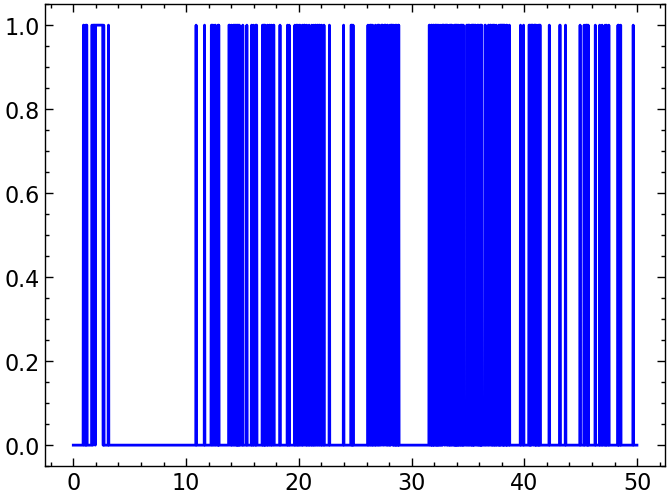

In [6]:
import matplotlib.pyplot as plt

da_distances = md.compute_distances(full_traj, pyc_hbonds[:, [1,2]], periodic=False)
da_angles = md.compute_angles(full_traj, pyc_hbonds, periodic=False)
distance_met = da_distances < 0.25
angle_met = da_angles > 2 * np.pi/3
hbond_met = np.logical_and(distance_met, angle_met)
num_hbonds = np.sum(hbond_met, axis=1)
plt.plot(full_traj.time/1000, num_hbonds,'b-')


So, according to `MDTraj` Baker-Hubbard hbond detector, there is **ONLY ONE** hydrogen bond at a time between protein and PYC that form at more than a frequency of `freq=` $0.01$ in the trajectory frames. This is consistent with the video from `VMD.`
But baker hubbard detects three types of bonds total, so this one bond is clearly not the same bond always.

VAL149-N - VAL149-H ... PYC389-O
ASN210-N - ASN210-H ... PYC389-O
ASN210-N - ASN210-H ... PYC389-N1
ASN210-ND2 - ASN210-HD21 ... PYC389-O

(0.0, 1.5)

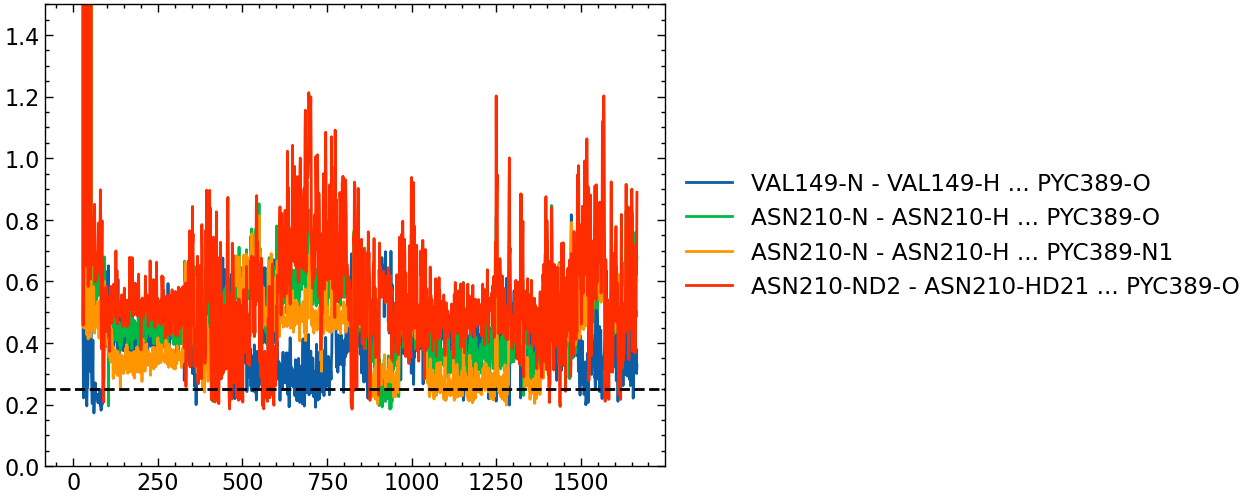

In [10]:
for hb in pyc_hbonds:
    distances = md.compute_distances(full_traj, [hb[1:3]], periodic=False)
    plt.plot(distances, label=label(hb))
plt.legend(ncol=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.axhline(0.25, color='black', linestyle='--')
plt.ylim(0, 1.5)